In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem.rdchem import RWMol
from rdkit.Chem import Draw
from rdkit.Chem import rdmolops
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Scaffolds import MurckoScaffold

IPythonConsole.ipython_useSVG = True

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset

import math
import pickle

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

/Users/whj/opt/anaconda3/envs/python38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read data
df_rdm = pd.read_csv('/Users/whj/Documents/hERG_ChEMBL240/Data/Imbalanced/ChEMBL240_1_30_1295_2052.csv')
df_rdm.head()

,Unnamed: 0,Canonical_smiles,Murcko,ClassD,No
0,2028,Fc1ccc(cc1)S(=O)(=O)NC(=O)NC2CCN(Cc3ccn(c3)c4c...,O=C(NC1CCN(Cc2ccn(-c3ccccc3)c2)CC1)NS(=O)(=O)c...,0,3
1,7239,COc1ccc(cc1)c2oc(nn2)C(=O)N3CCC(CC3)Oc4ccc(CN5...,O=C(c1nnc(-c2ccccc2)o1)N1CCC(Oc2ccc(CN3CCCC3)c...,0,6
2,6181,CN1C[C@H](c2ccc3sccc3c2)c4ccc(cc4C1)N5CCOCC5,c1cc2cc(C3CNCc4cc(N5CCOCC5)ccc43)ccc2s1,1,9
3,35,Oc1ccc(cc1)c2sc3cc(O)ccc3c2C(=O)c4ccc(OCCN5CCC...,O=C(c1ccc(OCCN2CCCCC2)cc1)c1c(-c2ccccc2)sc2ccc...,0,14
4,4256,CS(=O)(=O)Cc1cc(nc(n1)c2ccc3[nH]ccc3c2)N4CC5CC...,c1cc(N2CC3CCC(C2)O3)nc(-c2ccc3[nH]ccc3c2)n1,0,15


# Mol graph and feature

In [3]:
# define molecule with atom index method
def mol_with_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol
# define molecule convert to graph method: predefine 4 type and 45*45 matrix
def mol2graph(mol):
    out = np.zeros((4, 45, 45))
    mol = mol_with_atom_index(mol)
    # core use MurckoScaffold
    core = MurckoScaffold.GetScaffoldForMol(mol)
    # find both side atom of bond (put them into different types)    
    for bond in mol.GetBonds():
        typ = str(bond.GetBondType())
        begin_atom = bond.GetBeginAtom()
        end_atom = bond.GetEndAtom()
        begin_smb = bond.GetBeginAtom().GetSymbol()
        end_smb = bond.GetEndAtom().GetSymbol()
        begin = int(begin_atom.GetProp('molAtomMapNumber'))
        end = int(end_atom.GetProp('molAtomMapNumber'))
        # here is the second type: all atom type
        out[1, begin, end] = 1
        out[1, end, begin] = 1
        # here is the thrid type: aromatic ring type        
        if typ == "AROMATIC":  
            out[2, begin, end] = 1
            out[2, end, begin] = 1
        # here is the fourth type: heteroatom type         
        if (begin_smb == 'C' and end_smb in ('N','O','S')) or (begin_smb in ('N','O','S') and end_smb == 'C'):
            out[3, begin, end] = 1
            out[3, end, begin] = 1
            # here is the first type: scaffold core structure type  
    # core index needs to keep the same index with all atom index
    for bond in core.GetBonds(): 
        typ = str(bond.GetBondType())
        begin_atom = bond.GetBeginAtom()
        end_atom = bond.GetEndAtom()
        begin = int(begin_atom.GetProp('molAtomMapNumber'))
        end = int(end_atom.GetProp('molAtomMapNumber'))
        
        out[0, begin, end] = 1
        out[0, end, begin] = 1
        
    return out

In [4]:
# define a method for 36 atom features 
def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))
def atom_features(atom,
                  bool_id_feat=False,
                  explicit_H=False,
                  use_chirality=False):
    if bool_id_feat:
        return np.array([atom_to_id(atom)])
    else:
        from rdkit import Chem
        results = one_of_k_encoding_unk(
          atom.GetSymbol(),
          [
            'C', 
            'N',
            'O',
            'S',
            'F', 
            'P',
            'Cl',
            'Br',
            'Unknown'
              ]) + one_of_k_encoding_unk(atom.GetDegree(),
                             [1, 2, 3, 4, 5, 6, 'Max']) + \
              one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6]) + \
              [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
              one_of_k_encoding_unk(atom.GetHybridization(), [
                Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.
                                    SP3D, Chem.rdchem.HybridizationType.SP3D2
              ]) + [atom.GetIsAromatic()]
    
    # In case of explicit hydrogen(QM8, QM9), avoid calling `GetTotalNumHs`
    if not explicit_H:
        results = results + one_of_k_encoding_unk(atom.GetTotalNumHs(),
                                                [0, 1, 2, 3, 4])
    if use_chirality:
        
        try:
            results = results + one_of_k_encoding_unk(
                atom.GetProp('_CIPCode'),
                ['R', 'S']) + [atom.HasProp('_ChiralityPossible')]
        except:
            results = results + [False, False
                                ] + [atom.HasProp('_ChiralityPossible')]

    return np.array(results)

In [5]:
ckeckmol = Chem.MolFromSmiles('Cc1ccccc1')
# define a method: one-hot encoding for each atom in an molecule
def mol2feat(mol):
    atoms = mol.GetAtoms()
    res = np.zeros((45, 36)) # Set it
    for i,atom in enumerate(atoms):
        node_f = atom_features(atom)
        res[i,:] = node_f
    return res

print(mol2feat(ckeckmol).shape)
print(mol2graph(ckeckmol).shape)

(45, 36)
(4, 45, 45)


The following part could change by using different threshold datasets: from ClassA to ClassE

In [6]:
arr_A = np.zeros((3347, 45, 45, 4))
arr_X = np.zeros((3347, 45, 36))
label = np.zeros((3347,))

# transform molecule from smiles to graph structure, extract features for each atom, make label
for i,word in enumerate(list(df_rdm['Canonical_smiles'])):
    mol = Chem.MolFromSmiles(word) 
    adj = mol2graph(mol)
    adj = np.transpose(adj, (1,2,0))  
    feat = mol2feat(mol)    
    lab = list(df_rdm['ClassD'])[i]

    arr_A[i,:,:,:] = adj
    arr_X[i,:,:] = feat
    label[i] = lab

arr_A = np.float32(arr_A) 
arr_X = np.float32(arr_X)
label = np.expand_dims(label, axis=1) 
print(arr_A.shape)
print(arr_X.shape)
print(label.shape)

(3347, 45, 45, 4)
(3347, 45, 36)
(3347, 1)


# Networks

In [7]:
# from heterogeneous graph to homogeneous graph
class GTConv(nn.Module):    
    def __init__(self, in_channels, out_channels):
        super(GTConv, self).__init__()     
        self.in_channels = in_channels
        self.out_channels = out_channels
        # define a learnable weight
        self.weight = nn.Parameter(torch.Tensor(out_channels,in_channels,1,1))
        self.bias = None
        self.scale = nn.Parameter(torch.Tensor([0.1]), requires_grad=False)
        self.reset_parameters()
    
    def reset_parameters(self):
        n = self.in_channels
        nn.init.constant_(self.weight, 0.1)
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
    # calculate A * weight: sum function could be changed by any function such as max().
    def forward(self, A):
        Q = torch.sum(A * F.softmax(self.weight, dim=1), dim=1)
        return Q

class GTLayer(nn.Module):    
    def __init__(self, in_channels, out_channels, first=True):
        super(GTLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.first = first
        if self.first == True:
            self.conv1 = GTConv(in_channels, out_channels)
            self.conv2 = GTConv(in_channels, out_channels)
        else:
            self.conv1 = GTConv(in_channels, out_channels)
    
    def forward(self, A, A_p_=None):
        if self.first == True:
            Q_1 = self.conv1(A)
            Q_2 = self.conv2(A)
            A_p = torch.bmm(Q_1, Q_2)
            W = [(F.softmax(self.conv1.weight, dim=1)).detach(), (F.softmax(self.conv2.weight, dim=1)).detach()]
        else:
            Q = self.conv1(A)
            A_p = torch.bmm(A_p_, Q)
            W = [(F.softmax(self.conv1.weight, dim=1)).detach()]
        return A_p, W

class GTN(nn.Module):    
    def __init__(self, num_edge, num_channels, w_in, w_out, num_class, num_layers, norm):
        super(GTN, self).__init__()
        self.num_edge = num_edge
        self.num_channels = num_channels
        self.w_in = w_in
        self.w_out = w_out
        self.num_class = num_class
        self.num_layers = num_layers
        self.is_norm = norm
        layers = []
        for i in range(num_layers):
            if i == 0:
                layers.append(GTLayer(num_edge, num_channels, first=True))
            else:
                layers.append(GTLayer(num_edge, num_channels, first=False))
        self.layers = nn.ModuleList(layers)
        self.weight = nn.Parameter(torch.Tensor(w_in, w_out))
        self.bias = nn.Parameter(torch.Tensor(w_out))
        self.loss = nn.CrossEntropyLoss()
        self.linear1 = nn.Linear(self.w_out*self.num_channels, self.w_out)
        self.linear2 = nn.Linear(self.w_out, self.num_class)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def gcn_conv(self, N_f, A_p):
        N_f = torch.mm(N_f, self.weight)
        A_p = self.norm(A_p, add=True)
        return torch.mm(A_p.t(), N_f)
    
    def normalization(self, A_p):
        for i in range(self.num_channels):
            if i==0:
                A_p_ = self.norm(A_p[i,:,:]).unsqueeze(0)
            else:
                A_p_ = torch.cat((A_p_,self.norm(A_p[i,:,:]).unsqueeze(0)), dim=0)
        return A_p_

    def norm(self, A_p, add=False):
        A_p = A_p.t()
        if add == False:
            A_p = A_p*((torch.eye(A_p.shape[0])==0).type(torch.FloatTensor))
        else:
            A_p = A_p*((torch.eye(A_p.shape[0])==0).type(torch.FloatTensor)) + torch.eye(A_p.shape[0]).type(torch.FloatTensor)
        deg = torch.sum(A_p, dim=1)
        deg_inv = deg.pow(-1)
        deg_inv[deg_inv == float('inf')] = 0
        deg_inv = deg_inv*torch.eye(A_p.shape[0]).type(torch.FloatTensor)
        A_p = torch.mm(deg_inv, A_p)
        A_p = A_p.t()
        return A_p

    def forward(self, A, N_f): # A use for making meta-path
        A = A.unsqueeze(0).permute(0,3,1,2) #(1,64,64,4) -> (1,4,64,64)
        Ws = []
        leakyrelu = nn.LeakyReLU(0.1)
        for i in range(self.num_layers):
            if i == 0:
                A_p, W = self.layers[i](A) # H shape, torch.Size([chnnel, 64, 64])
            else:
                A_p = self.normalization(A_p)
                A_p, W = self.layers[i](A, A_p)
            Ws.append(W)
        

        for i in range(self.num_channels): # N_f and A_p use for general GCN
            if i==0:
                N_f_ = F.relu(self.gcn_conv(N_f,A_p[i])) # N_f: features, A_p: meta-path
            else:
                N_f_tmp = F.relu(self.gcn_conv(N_f,A_p[i]))
                N_f_ = torch.cat((N_f_,N_f_tmp), dim=1)

        N_f_ = torch.sum(N_f_, 0) #(45,36) -> (36,)
        N_f_ = self.linear1(N_f_) #(36,) -> (16,)
        N_f_ = leakyrelu(N_f_)
        N_f_ = self.linear2(N_f_) #(16,) -> (2)
        y = N_f_.unsqueeze(0)
        
        return y, Ws

In [8]:
# 10 fold cross validation
DEVICE = torch.device("cpu")
# example
k_folds = 10
epochs = 1

ac_list=[[],[],[],[],[],[],[],[],[],[]]
loss_list=[[],[],[],[],[],[],[],[],[],[]]
val_loss_list=[[],[],[],[],[],[],[],[],[],[]]

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=False)

# Start print
print("------Start-----------------")
# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(arr_A)):
    print(f'FOLD {fold}')
    
    #numpy to tensor
    tens_A = torch.from_numpy(arr_A)
    tens_X = torch.from_numpy(arr_X)
    tens_lab = torch.from_numpy(label)
    tens_lab = tens_lab.long()
    traindataset = torch.utils.data.TensorDataset(tens_A[train_ids], tens_X[train_ids], tens_lab[train_ids])
    testdataset = torch.utils.data.TensorDataset(tens_A[test_ids], tens_X[test_ids], tens_lab[test_ids])
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      traindataset, 
                      batch_size=1, shuffle=False)
    testloader = torch.utils.data.DataLoader(
                      testdataset,
                      batch_size=1, shuffle=False)
    
    # model parameters
    model = GTN(num_edge=4, # num of edge types 
            num_channels=1, # num of weight channel 
            w_in = 36, # node_features
            w_out = 64, 
            num_class = 2, # blocker or non-blocker
            num_layers= 1, # how many GTLayers: 1
            norm='true').to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters())
    celoss = nn.CrossEntropyLoss()

    acc_max = 0.01
    loss_min = 9999
    
    # training
    for i in range(epochs):
        count = 0
        running_loss = 0.0
        for batch_idx, (A, X, y) in enumerate(trainloader):

            A = A[0,:].to(DEVICE)
            X = X[0,:].to(DEVICE)
            model.zero_grad()
            y = y[0].to(DEVICE)
            pred, Ws = model(A, X)
            loss = celoss(pred, y)
            loss.backward()
            optimizer.step()
            count +=1
            running_loss += loss.item()   
        loss_loss =  running_loss/count
        loss_list[fold].append(loss_loss)
        print("Fold: ", fold, "-- epoch",i+1,"finished")
        print("train_loss:", loss_loss)

        count = 0
        pre = []
        lab = []
        loss_loss = 0.0
        running_loss = 0.0
        for batch_idx, (A, X, y) in enumerate(testloader):
            A = A[0,:].to(DEVICE)
            X = X[0,:].to(DEVICE)
            y = y[0].to(DEVICE)
            
            pred, Ws = model(A, X)
            loss = celoss(pred, y)
            running_loss += loss.item()
            
            count += 1
            
            _, y_pred = torch.max(pred.data, 1)
            y_pred = y_pred.detach().tolist()
            y = y.detach().tolist()
            pre = pre+y_pred
            lab = lab+y
        loss_loss = running_loss/count
        val_loss_list[fold].append(loss_loss)
        print("val_loss:", loss_loss)
        
        cl = classification_report(lab, pre, output_dict=True)
        print(classification_report(lab, pre))
        ac_list[fold].append(cl['accuracy'])

        if acc_max<cl['accuracy']:
            acc_max=cl['accuracy']
            save_path = f'Model/1_30/best_in_fold_{fold}.pth'
            torch.save(model.state_dict(), save_path)
            
        if loss_min>loss_loss:
            loss_min=loss_loss

        print('---------------------------------')
    

------Start-----------------
FOLD 0
Fold:  0 -- epoch 1 finished
train_loss: 0.5524454460623941
val_loss: 0.45406829606996296
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       199
           1       0.72      0.84      0.77       136

    accuracy                           0.80       335
   macro avg       0.80      0.81      0.80       335
weighted avg       0.81      0.80      0.80       335

---------------------------------
FOLD 1
Fold:  1 -- epoch 1 finished
train_loss: 0.5420620715483339
val_loss: 0.41981215717995524
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       217
           1       0.69      0.78      0.73       118

    accuracy                           0.80       335
   macro avg       0.78      0.80      0.79       335
weighted avg       0.81      0.80      0.80       335

---------------------------------
FOLD 2
Fold:  2 -- epoch 1 finished
train_loss: 0.54258

In [9]:
# save the results of 10 fold cross validation
for i in range(0,10):
    
    loss_l = pd.DataFrame(loss_list[i][1:], columns=None)
    val_loss_l = pd.DataFrame(val_loss_list[i][1:], columns=None)
    ac_l = pd.DataFrame(ac_list[i], columns=None)
    
    loss_l.to_csv(f'/Users/whj/Documents/hERG_ChEMBL240/Results/GTN/Imbalanced/Binary_threshold/1_30/Loss_fold_{i}.csv', index=False)
    val_loss_l.to_csv(f'/Users/whj/Documents/hERG_ChEMBL240/Results/GTN/Imbalanced/Binary_threshold/1_30/Vlos_fold_{i}.csv', index=False)
    ac_l.to_csv(f'/Users/whj/Documents/hERG_ChEMBL240/Results/GTN/Imbalanced/Binary_threshold/1_30/Acc_fold_{i}.csv', index=False)

In [10]:
# print the performance of 10 fold cross validation
DEVICE = torch.device("cpu")
print(DEVICE)

modeltest = GTN(num_edge=4, # num of edge types: 
            num_channels=1, 
            w_in = 36, # node_features
            w_out = 64, # we just define it
            num_class = 2, # 4
            num_layers= 1, # how many GTLayers: 1
            norm='true').to(DEVICE)

Pre = [[],[],[],[],[],[],[],[],[],[]]
Lab = [[],[],[],[],[],[],[],[],[],[]]

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=False)
for fold, (train_ids, test_ids) in enumerate(kfold.split(arr_A)):
    print(f'FOLD {fold}')
    

    testdataset = torch.utils.data.TensorDataset(tens_A[test_ids], tens_X[test_ids], tens_lab[test_ids])
    
    modeltest.load_state_dict(torch.load(f'Model/1_30/best_in_fold_{fold}.pth'))
    testloader2 = DataLoader(testdataset, batch_size=1, shuffle=False, drop_last=False)
   
    for batch_idx, (A, X, y) in enumerate(testloader2):
        A = A[0,:].to(DEVICE)
        X = X[0,:].to(DEVICE)
        y = y[0].to(DEVICE)
        pred, Ws = modeltest(A, X)

        _, y_pred = torch.max(pred.data, 1)
        y_pred = y_pred.detach().tolist()
        y = y.detach().tolist()
        Pre[fold].append(y_pred)
        Lab[fold].append(y)
        
    print("fold: ", fold, "\n", classification_report(Lab[fold], Pre[fold], output_dict=True))
    cm1 = confusion_matrix(Lab[fold], Pre[fold])
    tn, fp, fn, tp = confusion_matrix(Lab[fold], Pre[fold]).ravel()
    print("\n", "fold", fold)
    print(cm1)
    print("tn, fp, fn, tp: ", tn, fp, fn, tp)
    fpr, tpr, thresholds = metrics.roc_curve(Lab[fold], Pre[fold], pos_label=1)
    print("AUC: ", metrics.auc(fpr, tpr))
    GHa = (tp*((tp+fp)+(tp+fn))) / (2*(tp+fp)*(tp+fn))
    GHi = (tn*((tn+fn)+(tn+fp))) / (2*(tn+fn)*(tn+fp))
    print("GHa, GHi: ",GHa, GHi)
    NPV = tn/(tn+fn)
    print("NPV",NPV)
    print("===================")

cpu
FOLD 0
fold:  0 
 {'0': {'precision': 0.875, 'recall': 0.7738693467336684, 'f1-score': 0.8213333333333332, 'support': 199}, '1': {'precision': 0.7169811320754716, 'recall': 0.8382352941176471, 'f1-score': 0.7728813559322033, 'support': 136}, 'accuracy': 0.8, 'macro avg': {'precision': 0.7959905660377358, 'recall': 0.8060523204256578, 'f1-score': 0.7971073446327683, 'support': 335}, 'weighted avg': {'precision': 0.8108490566037736, 'recall': 0.8, 'f1-score': 0.801663276836158, 'support': 335}}

 fold 0
[[154  45]
 [ 22 114]]
tn, fp, fn, tp:  154 45 22 114
AUC:  0.8060523204256578
GHa, GHi:  0.7776082130965594 0.8244346733668342
NPV 0.875
FOLD 1
fold:  1 
 {'0': {'precision': 0.8712871287128713, 'recall': 0.8110599078341014, 'f1-score': 0.8400954653937948, 'support': 217}, '1': {'precision': 0.6917293233082706, 'recall': 0.7796610169491526, 'f1-score': 0.7330677290836655, 'support': 118}, 'accuracy': 0.8, 'macro avg': {'precision': 0.781508226010571, 'recall': 0.795360462391627, 'f1-

# prediction

In [11]:
# make test dataset
arr_A = np.float32(arr_A) 
arr_X = np.float32(arr_X) 
label = np.expand_dims(label, axis=1) 
print(arr_A.shape)

arr_A_test = arr_A[3012:,:]
arr_X_test = arr_X[3012:,:]
label_test = label[3012:,:]

tens_A_test = torch.from_numpy(arr_A_test)
tens_X_test = torch.from_numpy(arr_X_test)
tens_lab_test = torch.from_numpy(label_test)
tens_lab_test = tens_lab_test.long()

testdataset = torch.utils.data.TensorDataset(tens_A_test, tens_X_test, tens_lab_test)
testloader = DataLoader(testdataset, batch_size=1, shuffle=False, drop_last=True)

(3347, 45, 45, 4)


In [12]:
# test
DEVICE = torch.device("cpu")
print(DEVICE)

modeltest = GTN(num_edge=4, 
            num_channels=1, 
            w_in = 36, 
            w_out = 64, 
            num_class = 2, 
            num_layers= 1, 
            norm='true').to(DEVICE)

modeltest.load_state_dict(torch.load('Model/1_30_'))

Ws_list = []
pre = []
lab = []
for batch_idx, (A, X, y) in enumerate(testloader):
    A = A[0,:].to(DEVICE)
    X = X[0,:].to(DEVICE)
    y = y[0].to(DEVICE)
    pred, Ws = modeltest(A, X)
    Ws_list.append(np.asarray(Ws[0]))
 
    _, y_pred = torch.max(pred.data, 1)
    y_pred = y_pred.detach().tolist()
    y = y.detach().tolist()
    pre = pre+y_pred
    lab = lab+y
    
print(classification_report(lab, pre, output_dict=True))

cpu


/var/folders/ky/_hgjk81906j5ljcf9kx2ngkh0000gn/T/ipykernel_89425/1940954480.py:23: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ws_list.append(np.asarray(Ws[0]))
/var/folders/ky/_hgjk81906j5ljcf9kx2ngkh0000gn/T/ipykernel_89425/1940954480.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ws_list.append(np.asarray(Ws[0]))


{'0': {'precision': 0.9425837320574163, 'recall': 0.9425837320574163, 'f1-score': 0.9425837320574163, 'support': 209}, '1': {'precision': 0.9047619047619048, 'recall': 0.9047619047619048, 'f1-score': 0.9047619047619048, 'support': 126}, 'accuracy': 0.9283582089552239, 'macro avg': {'precision': 0.9236728184096605, 'recall': 0.9236728184096605, 'f1-score': 0.9236728184096605, 'support': 335}, 'weighted avg': {'precision': 0.9283582089552239, 'recall': 0.9283582089552239, 'f1-score': 0.9283582089552239, 'support': 335}}


In [13]:
# test pass or fail
df_rdm_test = df_rdm.loc[3012:,:]
df_rdm_test=df_rdm_test.copy()
lab = list(df_rdm_test['ClassD'])
res_lis = []
for i in range(len(lab)):
    if pre[i] == lab[i]:
        res_lis.append('Pass')
    if pre[i] != lab[i]:
        res_lis.append('Fail')

df_rdm_test["ib1_30"] = res_lis
df_rdm_test.head()

,Unnamed: 0,Canonical_smiles,Murcko,ClassD,No,ib1_30
3012,2471,Cc1ncoc1c2nnc(SCCCN3CC4CC4(C3)c5ccc(cc5F)C(F)(...,c1ccc(C23CC2CN(CCCSc2nnc(-c4cnco4)[nH]2)C3)cc1,1,7501,Pass
3013,301,CCCCN(CCCC)CCC(O)c1cc2c(Cl)cc(Cl)cc2c3cc(ccc13...,c1ccc2c(c1)ccc1ccccc12,1,7503,Pass
3014,4515,CCOC(=O)N1CCN(Cc2oc(nn2)c3cccc(Cl)c3)CC1,c1ccc(-c2nnc(CN3CCNCC3)o2)cc1,0,7505,Pass
3015,6608,NC(=O)c1cnc2[nH]ccc2c1NC3CCN(CC3)c4ccc(nn4)C#N,c1cnnc(N2CCC(Nc3ccnc4[nH]ccc34)CC2)c1,0,7511,Pass
3016,690,Fc1ccc2C(=O)C=C(Oc2c1)C(=O)NC3CCN(Cc4cc5OCOc5c...,O=C(NC1CCN(Cc2ccc3c(c2)OCO3)CC1)c1cc(=O)c2cccc...,1,7512,Pass


In [14]:
df_rdm_test.to_csv('/Users/whj/Documents/hERG_ChEMBL240/Results/GTN/Imbalanced/Binary_threshold/1_30/Test_result_1_30.csv')

# External prediction

In [15]:
# read FDA data and test
df_FDA = pd.read_csv('/Users/whj/Documents/hERG_ChEMBL240/Data/FDA_drugs/FDA_1_30.csv')
df_FDA.head()

,Unnamed: 0,Canonical_smiles,FDA_drug,Murcko,hERG IC50 (μM),ClassD
0,0,CN1CCC[C@H]1C2=CN=CC=C2,Nicotine,c1cncc(C2CCCN2)c1,245.000,0
1,6,CN1CCN(CC1)C2=NC3=C(C=CC(=C3)Cl)NC4=CC=CC=C42,Clozapine,c1ccc2c(c1)N=C(N1CCNCC1)c1ccccc1N2,0.324,1
2,11,COC1=CC2=C(C=CN=C2C=C1)[C@@H]([C@H]3C[C@@H]4CC...,Quinidine,c1ccc2c(CC3CC4CCN3CC4)ccnc2c1,0.324,1
3,14,CC1=C(C(=O)N2CCCCC2=N1)CCN3CCC(CC3)C4=NOC5=C4C...,Risperidone,O=c1c(CCN2CCC(c3noc4ccccc34)CC2)cnc2n1CCCC2,0.151,1
4,15,CC(C)C(CCCN(C)CCC1=CC(=C(C=C1)OC)OC)(C#N)C2=CC...,Verapamil,c1ccc(CCCCNCCc2ccccc2)cc1,0.141,1


In [16]:
len(df_FDA)

25

In [17]:
# make test dataset

arr_A = np.zeros((25, 45, 45, 4)) # delete 10 mols which over 45 atoms
arr_X = np.zeros((25, 45, 36))
label = np.zeros((25,))

for i,word in enumerate(list(df_FDA['Canonical_smiles'])):
    mol = Chem.MolFromSmiles(word) #mol
    adj = mol2graph(mol)

    adj = np.transpose(adj, (1,2,0))
    feat = mol2feat(mol)
    lab = list(df_FDA['ClassD'])[i]

    arr_A[i,:,:,:] = adj
    arr_X[i,:,:] = feat
    label[i] = lab


arr_A = np.float32(arr_A) 
arr_X = np.float32(arr_X) 
label = np.expand_dims(label, axis=1) 
print(arr_A.shape)

arr_A_test = arr_A
arr_X_test = arr_X
label_test = label

tens_A_test = torch.from_numpy(arr_A_test)
tens_X_test = torch.from_numpy(arr_X_test)
tens_lab_test = torch.from_numpy(label_test)
tens_lab_test = tens_lab_test.long()

testdataset = torch.utils.data.TensorDataset(tens_A_test, tens_X_test, tens_lab_test)
testloader = DataLoader(testdataset, batch_size=1, shuffle=False, drop_last=True)

(25, 45, 45, 4)


In [18]:
# test
DEVICE = torch.device("cpu")
print(DEVICE)

modeltest = GTN(num_edge=4, 
            num_channels=1, 
            w_in = 36, 
            w_out = 64, 
            num_class = 2, 
            num_layers= 1, 
            norm='true').to(DEVICE)

modeltest.load_state_dict(torch.load('Model/1_30_'))

Ws_list = []
pre = []
lab = []
for batch_idx, (A, X, y) in enumerate(testloader):
    A = A[0,:].to(DEVICE)
    X = X[0,:].to(DEVICE)
    y = y[0].to(DEVICE)
    pred, Ws = modeltest(A, X)
    Ws_list.append(np.asarray(Ws[0]))
 
    _, y_pred = torch.max(pred.data, 1)
    y_pred = y_pred.detach().tolist()
    y = y.detach().tolist()
    pre = pre+y_pred
    lab = lab+y
    
print(classification_report(lab, pre, output_dict=True))

cpu
{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 15}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 25}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 25}}


/var/folders/ky/_hgjk81906j5ljcf9kx2ngkh0000gn/T/ipykernel_89425/1940954480.py:23: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ws_list.append(np.asarray(Ws[0]))
/var/folders/ky/_hgjk81906j5ljcf9kx2ngkh0000gn/T/ipykernel_89425/1940954480.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ws_list.append(np.asarray(Ws[0]))


In [19]:
# test pass or fail
df_FDA = df_FDA
df_FDA=df_FDA.copy()
lab = list(df_FDA['ClassD'])
res_lis = []
for i in range(len(lab)):
    if pre[i] == lab[i]:
        res_lis.append('Pass')
    if pre[i] != lab[i]:
        res_lis.append('Fail')

df_FDA["ib1_30"] = res_lis
df_FDA.head()

,Unnamed: 0,Canonical_smiles,FDA_drug,Murcko,hERG IC50 (μM),ClassD,ib1_30
0,0,CN1CCC[C@H]1C2=CN=CC=C2,Nicotine,c1cncc(C2CCCN2)c1,245.000,0,Pass
1,6,CN1CCN(CC1)C2=NC3=C(C=CC(=C3)Cl)NC4=CC=CC=C42,Clozapine,c1ccc2c(c1)N=C(N1CCNCC1)c1ccccc1N2,0.324,1,Pass
2,11,COC1=CC2=C(C=CN=C2C=C1)[C@@H]([C@H]3C[C@@H]4CC...,Quinidine,c1ccc2c(CC3CC4CCN3CC4)ccnc2c1,0.324,1,Pass
3,14,CC1=C(C(=O)N2CCCCC2=N1)CCN3CCC(CC3)C4=NOC5=C4C...,Risperidone,O=c1c(CCN2CCC(c3noc4ccccc34)CC2)cnc2n1CCCC2,0.151,1,Pass
4,15,CC(C)C(CCCN(C)CCC1=CC(=C(C=C1)OC)OC)(C#N)C2=CC...,Verapamil,c1ccc(CCCCNCCc2ccccc2)cc1,0.141,1,Pass


In [20]:
df_FDA.to_csv('/Users/whj/Documents/hERG_ChEMBL240/Results/GTN/Imbalanced/Binary_threshold/1_30/FDA_result_1_30.csv')

In [21]:
pre

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]

In [22]:
lab

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]

# interpret

In [30]:
# from heterogeneous graph to homogeneous graph
class GTConv(nn.Module):    
    def __init__(self, in_channels, out_channels):
        super(GTConv, self).__init__()     
        self.in_channels = in_channels
        self.out_channels = out_channels
        # define a learnable weight
        self.weight = nn.Parameter(torch.Tensor(out_channels,in_channels,1,1))
        self.bias = None
        self.scale = nn.Parameter(torch.Tensor([0.1]), requires_grad=False)
        self.reset_parameters()
    
    def reset_parameters(self):
        n = self.in_channels
        nn.init.constant_(self.weight, 0.1)
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
    # calculate A * weight: sum function could be changed by any function such as max().
    def forward(self, A):
        Q = torch.sum(A * F.softmax(self.weight, dim=1), dim=1)
        return Q

class GTLayer(nn.Module):    
    def __init__(self, in_channels, out_channels, first=True):
        super(GTLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.first = first
        if self.first == True:
            self.conv1 = GTConv(in_channels, out_channels)
            self.conv2 = GTConv(in_channels, out_channels)
        else:
            self.conv1 = GTConv(in_channels, out_channels)
    
    def forward(self, A, A_p_=None):
        if self.first == True:
            Q_1 = self.conv1(A)
            Q_2 = self.conv2(A)
            A_p = torch.bmm(Q_1, Q_2)
            W = [(F.softmax(self.conv1.weight, dim=1)).detach(), (F.softmax(self.conv2.weight, dim=1)).detach()]
        else:
            Q = self.conv1(A)
            A_p = torch.bmm(A_p_, Q)
            W = [(F.softmax(self.conv1.weight, dim=1)).detach()]
        return A_p, W, Q_1, Q_2

class GTN(nn.Module):    
    def __init__(self, num_edge, num_channels, w_in, w_out, num_class, num_layers, norm):
        super(GTN, self).__init__()
        self.num_edge = num_edge
        self.num_channels = num_channels
        self.w_in = w_in
        self.w_out = w_out
        self.num_class = num_class
        self.num_layers = num_layers
        self.is_norm = norm
        layers = []
        for i in range(num_layers):
            if i == 0:
                layers.append(GTLayer(num_edge, num_channels, first=True))
            else:
                layers.append(GTLayer(num_edge, num_channels, first=False))
        self.layers = nn.ModuleList(layers)
        self.weight = nn.Parameter(torch.Tensor(w_in, w_out))
        self.bias = nn.Parameter(torch.Tensor(w_out))
        self.loss = nn.CrossEntropyLoss()
        self.linear1 = nn.Linear(self.w_out*self.num_channels, self.w_out)
        self.linear2 = nn.Linear(self.w_out, self.num_class)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def gcn_conv(self, N_f, A_p):
        N_f = torch.mm(N_f, self.weight)
        A_p = self.norm(A_p, add=True)
        return torch.mm(A_p.t(), N_f)
    
    def normalization(self, A_p):
        for i in range(self.num_channels):
            if i==0:
                A_p_ = self.norm(A_p[i,:,:]).unsqueeze(0)
            else:
                A_p_ = torch.cat((A_p_,self.norm(A_p[i,:,:]).unsqueeze(0)), dim=0)
        return A_p_

    def norm(self, A_p, add=False):
        A_p = A_p.t()
        if add == False:
            A_p = A_p*((torch.eye(A_p.shape[0])==0).type(torch.FloatTensor))
        else:
            A_p = A_p*((torch.eye(A_p.shape[0])==0).type(torch.FloatTensor)) + torch.eye(A_p.shape[0]).type(torch.FloatTensor)
        deg = torch.sum(A_p, dim=1)
        deg_inv = deg.pow(-1)
        deg_inv[deg_inv == float('inf')] = 0
        deg_inv = deg_inv*torch.eye(A_p.shape[0]).type(torch.FloatTensor)
        A_p = torch.mm(deg_inv, A_p)
        A_p = A_p.t()
        return A_p

    def forward(self, A, N_f): # A use for making meta-path
        A = A.unsqueeze(0).permute(0,3,1,2) #(1,64,64,4) -> (1,4,64,64)
        Ws = []
        leakyrelu = nn.LeakyReLU(0.1)
        for i in range(self.num_layers):
            if i == 0:
                A_p, W, Q_1, Q_2 = self.layers[i](A) # H shape, torch.Size([chnnel, 64, 64])
            else:
                A_p = self.normalization(A_p)
                A_p, W = self.layers[i](A, A_p)
            Ws.append(W)
        

        for i in range(self.num_channels): # N_f and A_p use for general GCN
            if i==0:
                N_f_ = F.relu(self.gcn_conv(N_f,A_p[i])) # N_f: features, A_p: meta-path
            else:
                N_f_tmp = F.relu(self.gcn_conv(N_f,A_p[i]))
                N_f_ = torch.cat((N_f_,N_f_tmp), dim=1)

        N_f_ = torch.sum(N_f_, 0) #(45,36) -> (36,)
        N_f_ = self.linear1(N_f_) #(36,) -> (16,)
        N_f_ = leakyrelu(N_f_)
        N_f_ = self.linear2(N_f_) #(16,) -> (2)
        y = N_f_.unsqueeze(0)
        
        return y, Ws, A_p, Q_1, Q_2

torch.Size([45, 45, 4])
torch.Size([45, 36])
[[tensor([[[[0.0865]],

         [[0.3513]],

         [[0.0742]],

         [[0.4880]]]]), tensor([[[[0.2668]],

         [[0.5194]],

         [[0.1563]],

         [[0.0575]]]])]]
The 0 Mol:



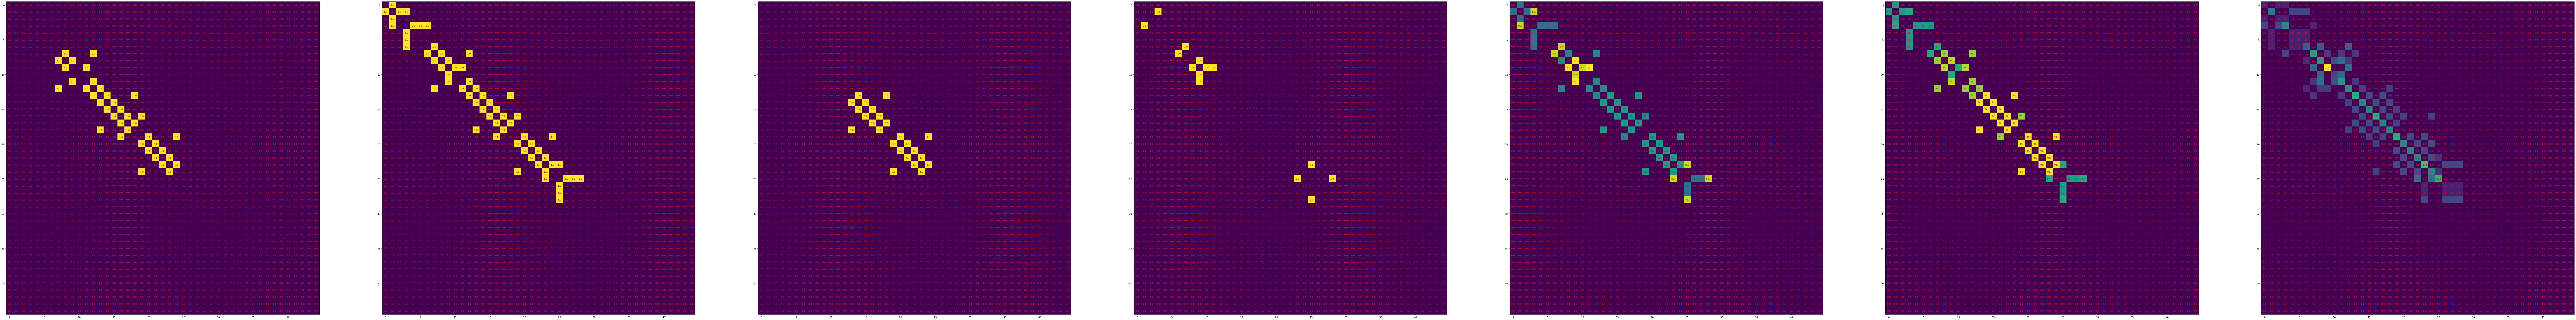

In [32]:
# Input only one mol:
ckeckmol = Chem.MolFromSmiles('CC(C)S(=O)(=O)N[C@H]1CN(C)C[C@@H]1c2ccc(cc2)c3cccc(c3)S(=O)(=O)C')
DEVICE = torch.device("cpu")
model = GTN(num_edge=4, # num of edge types: 
            num_channels=1, 
            w_in = 36, # node_features
            w_out = 64, # we just define it
            num_class = 2, # 4
            num_layers= 1, # how many GTLayers: 1
            norm='true').to(DEVICE)
model.load_state_dict(torch.load('Model/best_in_fold_9.pth'))

X = mol2feat(ckeckmol)
A = mol2graph(ckeckmol)

# plt.imshow(A[0,:])
A = np.transpose(A, (1,2,0))
tenA = torch.from_numpy(A).to(DEVICE)
tenX = torch.from_numpy(X).to(DEVICE)
tenA = tenA.type(torch.float)
tenX = tenX.type(torch.float)
print(tenA.shape)
print(tenX.shape)
# plt.imshow(tenA[0:45,0:45,0].detach().numpy())


Hs = []
a_s = []
b_s = []

# for batch_idx, (A, X, y) in enumerate(testloader):
#     A = A[0,:].to(DEVICE)
#     X = X[0,:].to(DEVICE)
pred, Ws, H, a, b = model(tenA, tenX)
Hs.append(H)
a_s.append(a)
b_s.append(b)

print(Ws)
for i in range(1):
    print("The",i, "Mol:"+"\n")
    fig = plt.figure(figsize=(200, 60))
    
    ax = fig.add_subplot(1,7,1)
    plt.imshow(tenA[:,:,0].numpy())
#     plt.title("A_Scaff:"+str(i))
    for x in range(45):
        for y in range(45):
            text = ax.text(y, x, tenA[:,:,0].numpy()[x, y],
                       ha="center", va="center", color="r")
    
    ax = fig.add_subplot(1,7,2)
    plt.imshow(tenA[:,:,1].numpy())
#     plt.title("A_ALL:"+str(i))
    for x in range(45):
        for y in range(45):
            text = ax.text(y, x, tenA[:,:,1].numpy()[x, y],
                       ha="center", va="center", color="r")

    
    ax = fig.add_subplot(1,7,3)
    plt.imshow(tenA[:,:,2].numpy())
#     plt.title("A_Aroma:"+str(i))
    for x in range(45):
        for y in range(45):
            text = ax.text(y, x, tenA[:,:,2].numpy()[x, y],
                       ha="center", va="center", color="r")
    
    ax = fig.add_subplot(1,7,4)
    plt.imshow(tenA[:,:,3].numpy())
#     plt.title("A_NOS:"+str(i))
    for x in range(45):
        for y in range(45):
            text = ax.text(y, x, tenA[:,:,3].numpy()[x, y],
                       ha="center", va="center", color="r")
    
    ax = fig.add_subplot(1,7,5)
    plt.imshow(a_s[i][0,:,:].detach().numpy())
#     plt.title("a:"+str(i))
    for x in range(45):
        for y in range(45):
            strr = str(100*a_s[i][0,:,:].detach().numpy()[x, y])
            text = ax.text(y, x, strr[0:3],
                       ha="center", va="center", color="r")
            
    ax = fig.add_subplot(1,7,6)
    plt.imshow(b_s[i][0,:,:].detach().numpy())
#     plt.title("b:"+str(i))
    for x in range(45):
        for y in range(45):
            strr = str(100*b_s[i][0,:,:].detach().numpy()[x, y])
            text = ax.text(y, x, strr[0:3],
                       ha="center", va="center", color="r")
    
    ax = fig.add_subplot(1,7,7)
    plt.imshow(Hs[i][0,:,:].detach().numpy())
#     plt.title("H:"+str(i))
    for x in range(45):
        for y in range(45):
            strr = str(100*Hs[i][0,:,:].detach().numpy()[x, y])
            text = ax.text(y, x, strr[0:3],
                       ha="center", va="center", color="r")
        

            
    plt.savefig('/Users/whj/Documents/hERG_ChEMBL240/Results/GTN/Imbalanced/Binary_threshold/1_30/diff4_1.png')